# Sea ice maps for ACCESS-OM2_01
TODO: compare thickness with cryosat data?

In [1]:
%matplotlib inline
import cosima_cookbook as cc
from dask.distributed import Client
from glob import glob
import os,sys
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.ticker as mticker
import numpy as np
import xarray as xr
import netCDF4 as nc
from tqdm import tqdm_notebook
import cartopy.crs as ccrs
import cartopy.feature as cft
#from mpl_toolkits.basemap import Basemap
from calendar import month_abbr
import cmocean as cm
import pandas as pd
import calendar
import cftime
from datetime import timedelta
from datetime import datetime
import copy
# import cartopy.crs as ccrs
# import cartopy.feature as cft

#import sys, os
#sys.path.append(os.path.join(os.getcwd(), '..'))  # so we can import ../exptdata
import exptdata
#print('Available exptdata keys: ', [k for k in exptdata.exptdict.keys()])

# set up time units and offset to suit CICE 
# see https://github.com/OceansAus/ACCESS-OM2-1-025-010deg-report/commit/ce3b6331bc4f304d2c5f957ccd2a0ae9ca5d6970#commitcomment-31646163
# for e in exptdata.exptdict.keys():
#     exptdata.exptdict[e]['time_units'] = None

# Set up time_units to suit CICE 
# Only retain netcdf time_units for 0.1 deg.
# We need to change time_units of 1deg and 0.25 deg 
# to shift the time so the last cycle starts in 1958.
# But we don't need offset because CICE time starts at beginning of run, 
# unlike MOM which starts in year 0001.
#exptdata.exptdict['01deg']['time_units'] = "days since 1985-01-01"  # don't use None - it leaves the time as cftime

In [2]:
import climtas.nci
climtas.nci.GadiClient()

Client Scheduler: tcp://127.0.0.1:35893 Dashboard: /proxy/8787/status,Cluster Workers: 8 Cores: 8 Memory: 137.44 GB


In [3]:
figdir = 'figs'
dpi=200
if not os.path.exists(figdir):
    os.makedirs(figdir)

def figname(fname, figdir=figdir):
    return os.path.join(figdir, fname+'_'+str(dpi)+'dpi.png')

def savefigure(fname, skip=False):
    if not(os.path.exists(fname) and skip):
        plt.savefig(fname, dpi=dpi, bbox_inches='tight')  # comment out to disable saving
        pass
    return

## Data loading definitions

In [4]:
# for comparison to fig 4 of WangIlicakGerdesDrangeAksenovBaileyBentsenBiastochBozec2016a
tstart = pd.to_datetime('2007', format='%Y')
tend = tstart + pd.DateOffset(years=1)

In [5]:
# use common start and end dates for all runs
tstart = exptdata.clim_tstart
tend = exptdata.clim_tend

In [6]:
# tstart = tend - pd.DateOffset(years=2)  # just the last bit for testing

In [7]:
tstart = pd.to_datetime('1958', format='%Y')
tend = pd.to_datetime('2019', format='%Y')

In [8]:
timerange=slice(tstart, tend)
firstyear = pd.to_datetime(tstart).year  # assumes tstart is 1 January!
lastyear = pd.to_datetime(tend).year-1  # assumes tend is 1 January!
yearrange = str(firstyear)+'-'+str(lastyear)
print(yearrange)
print('tstart = ', tstart)
print('tend = ', tend)

1958-2018
tstart =  1958-01-01 00:00:00
tend =  2019-01-01 00:00:00


In [9]:
def fixcicetime(da):
    '''
    Correct the time coordinate in DataArray from CICE netcdf file.
    
    CICE netcdf files unhelpfully have a time coordinate which is just after the end of the averaging period, 
    e.g. the time stamp for a January average is 1 February, which messes up groupby month etc.
    
    This function just subtracts 12 hours to put it in the correct month (and day, for daily means).
    
    PR 109 gives an option to fix this:
    https://github.com/OceansAus/cosima-cookbook/pull/109
    
    '''
    try:
        da['time'] = da.time - np.timedelta64(12, 'h')
    except:
        da['time'] = da.time - timedelta(hours=12)  # for 01deg which for some reason uses cftime
    return da

# use this for DataSet: replaces the bad time dimension with the average of time_bounds.
#     The time type is also changed to datetime64[ns]
#     ds['time'] = ds.time_bounds.astype('int64').mean(axis=1).astype('datetime64[ns]')
    

In [10]:
def loaddata(ide, varnames=['aice_m'], timerange=timerange): #, 'hi_m']): #, 'hs_m', 'vicen_m']):
# load model data
#   NB: varnames must be t-grid variables!!

    grids = [(p, xr.open_dataset(p)) for p in ide['gridpaths']]
    for k in ['xt_ocean', 'yt_ocean', 'geolon_t', 'geolat_t', 'area_t']:
        if k not in ide:
            for (p, g) in grids:
                try:
                    ide[k] = g[k]
                    print(k, 'loaded from', p)
                    break
                except:
                    continue
            try:
                ide[k] = ide[k].rename({'grid_x_T': 'xt_ocean', 'grid_y_T': 'yt_ocean'}) # fix for 01deg
            except:
                pass

    for varname in varnames:
        print(varname)
        if varname not in ide.keys():
            var = fixcicetime(cc.querying.getvar(ide['expt'], varname, ide['session'], 
                                                 start_time=str(timerange.start),
                                                 end_time=str(timerange.stop+timedelta(hours=12)),  # tweak since fixcicetime hasn't been applied yet
                                                 decode_coords=False)).sel(time=timerange)
            # use physical coords instead of indices - ASSUMES VARIABLES ARE ON T GRID!
            var.coords['ni'] = ide['xt_ocean'].data
            var.coords['nj'] = ide['yt_ocean'].data
            var = var.rename(({'ni': 'xt_ocean', 'nj': 'yt_ocean'}))
            var = var.assign_coords({'latitude': ide['geolat_t'], 'longitude': ide['geolon_t']})
            ide[varname] = var
            varmm = var.groupby('time.month').mean('time', skipna=True)
            ide[varname+'_mm'] = varmm

In [11]:
def get_sic_obs(obsFileList, years, months, variable='goddard_merged_seaice_conc_monthly'): # seaice_conc_monthly_cdr'): # 
    '''
    Return a dataarray from the monthly nc files in obsFileList.
    '''
    dataarrays = []
    for year in tqdm_notebook(years, leave=False, desc='year'):
        for month in tqdm_notebook(months, leave=False, desc='month'):
            obs_fname = [IceFile for IceFile in obsFileList if IceFile[-16:-10]==str(year)+str(month).zfill(2)][0]
            dataarray = xr.open_dataset(obs_fname,
                                        decode_times=False,
                                        autoclose=True)[variable]
            dataarrays.append(dataarray)
    dataarray = xr.concat(dataarrays, dim='time', coords='all')
    if 'time' in dataarray.coords:
        time_units = dataarray.time.units
        decoded_time = xr.conventions.times.decode_cf_datetime(dataarray.time, time_units)
        dataarray.coords['time'] = ('time', decoded_time,
                                    {'long_name': 'time', 'decoded_using': time_units }
                                   )

#     dataarray.coords['longitude'] = dataarray.coords['longitude'].isel(time=0)
#     dataarray.coords['latitude'] = dataarray.coords['latitude'].isel(time=0)

#     dataarray.coords['longitude'] = dataarray.longitude.isel(time=0)
#     dataarray.coords['latitude'] = dataarray.latitude.isel(time=0)


    # replace values outside valid range with nan
    dataarray = dataarray.where(xr.ufuncs.logical_and(dataarray>=0, dataarray<=1), np.nan)

    return dataarray

In [12]:
def get_sic_obs_daily(obsFileList, years=range(1978, 2020), months=range(1, 13), days=range(1, 32), variable='goddard_merged_seaice_conc'): 
    '''
    Return a dataarray from the daily nc files in obsFileList.
    '''
    dataarrays = []
    for year in tqdm_notebook(years, leave=False, desc='year'):
        for month in tqdm_notebook(months, leave=False, desc='month'):
            for day in days:
                datestr = ''.join([str(year), str(month).zfill(2), str(day).zfill(2)])
                obs_fname = [ IceFile for IceFile in obsFileList if os.path.basename(IceFile).split('_')[5]==datestr ]  # this is pretty inefficient!
                
                if len(obs_fname)>0:
                    dataarray = xr.open_dataset(obs_fname[0],
                                                decode_times=False,
                                                autoclose=True)[variable]
                    dataarrays.append(dataarray)
    dataarray = xr.concat(dataarrays, dim='time', coords='all')
    if 'time' in dataarray.coords:
        time_units = dataarray.time.units
        decoded_time = xr.conventions.times.decode_cf_datetime(dataarray.time, time_units)
        dataarray.coords['time'] = ('time', decoded_time,
                                    {'long_name': 'time', 'decoded_using': time_units }
                                   )

#     dataarray.coords['longitude'] = dataarray.coords['longitude'].isel(time=0)
#     dataarray.coords['latitude'] = dataarray.coords['latitude'].isel(time=0)

#     dataarray.coords['longitude'] = dataarray.longitude.isel(time=0)
#     dataarray.coords['latitude'] = dataarray.latitude.isel(time=0)


    # replace values outside valid range with nan
    dataarray = dataarray.where(xr.ufuncs.logical_and(dataarray>=0, dataarray<=1), np.nan)

    return dataarray

In [13]:
def get_sit_obs(obsFileList, years, months, variable='SIT'):
    '''
    Return a dataarray from the nc files in obsFileList.
    '''
    dataarrays = []
    for year in tqdm_notebook(years, leave=False, desc='year'):
        for month in tqdm_notebook(months, leave=False, desc='month'):
            obs_fname = [IceFile for IceFile in obsFileList if IceFile.split('_')[-2:]==[str(year),str(month).zfill(2)+'.nc']][0]
            dataarray = xr.open_dataset(obs_fname,
                                        decode_times=False,
                                        autoclose=True)[variable]
            dataarrays.append(dataarray)
    dataarray = xr.concat(dataarrays, dim='time', coords='all')
    
    # need to fix time axis - it is integers YYYYMM (!)
    if 'time' in dataarray.coords:
        decoded_time = xr.DataArray([datetime.strptime(str(d)+'15', '%Y%m%d') for d in dataarray['time'].data])
        dataarray.coords['time'] = ('time', decoded_time,
                                    {'long_name': 'time'}
                                   )

    dataarray = dataarray.rename({'lat': 'latitude', 'lon': 'longitude'})

    return dataarray

In [14]:
def obs_clim(obs, groupby='time.month'):
    cobs = obs.groupby(groupby).mean('time', skipna=True)
    cobs = cobs.assign_coords({'latitude': obs.latitude.isel(time=0),
                              'longitude': obs.longitude.isel(time=0)})
    return cobs

## Load data

### Load ACCESS-OM2 model data

In [15]:
# save concentration for all resolutions to do extent contours
ice_data = exptdata.exptdict

In [ ]:
for ekey in ice_data.keys():
    for ide in ice_data[ekey]:
#         loaddata(ide, varnames=['aice_m'])
#         loaddata(ide, varnames=['hi_m'])
        loaddata(ide, varnames=['hi'])
        loaddata(ide, varnames=['aice'])
        break  # only load cycle 1

hi
aice
xt_ocean loaded from /g/data/ik11/grids/ocean_grid_10.nc
yt_ocean loaded from /g/data/ik11/grids/ocean_grid_10.nc
geolon_t loaded from /g/data/ik11/grids/ocean_grid_10.nc
geolat_t loaded from /g/data/ik11/grids/ocean_grid_10.nc
area_t loaded from /g/data/ik11/grids/ocean_grid_10.nc
hi
aice
xt_ocean loaded from /g/data/ik11/grids/ocean_grid_10.nc
yt_ocean loaded from /g/data/ik11/grids/ocean_grid_10.nc
geolon_t loaded from /g/data/ik11/grids/ocean_grid_10.nc
geolat_t loaded from /g/data/ik11/grids/ocean_grid_10.nc
area_t loaded from /g/data/ik11/grids/ocean_grid_10.nc
hi


### Load SIC observational data

In [16]:
# Specify paths to observational data

# monthly ice concentration maps
ObsDir = '/g/data3/hh5/tmp/cosima/observations/NOAA/G02202_V3'  # from http://nsidc.org/data/G02202
obsNHFileList = glob(os.path.join(ObsDir, 'north/monthly/*.nc'))
obsSHFileList = glob(os.path.join(ObsDir, 'south/monthly/*.nc'))
obsNHFileList.sort()
obsSHFileList.sort()

# daily ice concentration maps
obsNHFileListDaily = glob(os.path.join(ObsDir, 'north/daily/*/*.nc'))
obsSHFileListDaily = glob(os.path.join(ObsDir, 'south/daily/*/*.nc'))
obsNHFileListDaily.sort()
obsSHFileListDaily.sort()

# Total icea area timeseries
ObsDirExt = '/g/data3/hh5/tmp/cosima/observations/NOAA/G02135'  # from http://nsidc.org/data/g02135
obsExtNHFileList = glob(os.path.join(ObsDirExt, 'north/monthly/data/*.csv'))
obsExtSHFileList = glob(os.path.join(ObsDirExt, 'south/monthly/data/*.csv'))
obsExtNHFileList.sort()
obsExtSHFileList.sort()

In [17]:
years = range(firstyear, lastyear+1)
months = range(1,13)

In [41]:
obs_NH = get_sic_obs(obsNHFileList, years, months).sel(time=timerange)
obs_SH = get_sic_obs(obsSHFileList, years, months).sel(time=timerange)

In [17]:
obs_NH_daily = get_sic_obs_daily(obsNHFileListDaily, years).sel(time=timerange)
obs_SH_daily = get_sic_obs_daily(obsSHFileListDaily, years).sel(time=timerange)

In [46]:
obs_NH_mm = obs_clim(obs_NH)
obs_SH_mm = obs_clim(obs_SH)

### Load GIOMAS thickness data

In [71]:
sitDir = '/g/data/v14/pas548/obs/seaice/giomas'
sitFileList = glob(os.path.join(sitDir, 'GIOMAS_sea-ice_????_??.nc'))
sitFileList.sort()
GIOMAS = get_sit_obs(sitFileList, range(firstyear, lastyear+1), range(1,13))
GIOMAS_mm = GIOMAS.groupby('time.month').mean('time', skipna=True)

# Generate plots

In [48]:
# based on https://cosima-recipes.readthedocs.io/en/latest/tutorials/Making_Maps_with_Cartopy.html#gallery-tutorials-making-maps-with-cartopy-ipynb

def plotSIC(var, projection=ccrs.NorthPolarStereo(), extent=[-180, 180, 48, 90],
           levels=np.arange(0,1.01,.1), cmp=plt.get_cmap('nipy_spectral'),
           cmap_gamma=2., # NB: non-1 gamma only works for fields and ticklevels in range [0, 1]
           cbar_ticklevels=[0,.3,.4,.5,.6,.7,.8,.85,.9,.95,1],  # for cmap_gamma = 2.
#            cmap_gamma = 4., cbar_ticklevels = [0,.5,.6,.7,.8,.85,.9,.95,.98,1],  # for cmap_gamma = 4.
           cbar_sigfigs=2, cbar_fontsize=12, cbar_label='Sea ice concentration', extend='neither', colorbar=True,
           lon_grid=range(-360, 361, 30), lat_grid=range(-80, 81, 10),
           feature=cft.NaturalEarthFeature('physical', 'land', '50m',
                                   edgecolor='black', facecolor=[.6, .6, .6], 
                                   linewidth=0.25)):
    var = var**cmap_gamma
    plt.figure(figsize=(12,7))
    ax = plt.axes(projection=projection)
#     ax.set_facecolor(cmp(0))
    ax.set_facecolor([.4, .4, .4])
#     ax.coastlines(resolution='50m', linewidth=0.5)
    ax.add_feature(feature)
    gl = ax.gridlines(draw_labels=True,
                      linewidth=0.5, color=[0.8, 0.8, 0.8], alpha=0.5)
    gl.ylabels_top = None

#     gl.ylabels_bottom = None # only needed for Weddell and Amundsen-Bellingshausen closeups
#     gl.ylabels_left = None # only needed for Weddell and Amundsen-Bellingshausen closeups
#     gl.ylabels_right = None # only needed for Weddell and Amundsen-Bellingshausen closeups

#     gl.ylabels_right = None
    gl.xlabels_top = None
    gl.xlabels_bottom = None
    gl.xlabels_left = None
    gl.xlabels_right = None
    gl.xlocator = mticker.FixedLocator(lon_grid)
    gl.ylocator = mticker.FixedLocator(lat_grid)

#     contourf is buggy near poles, so use pcolormesh instead
#    p1 = var.plot.contourf(ax=ax,
#                           x='longitude', y='latitude',
#                           levels=levels, #vmin=0, vmax=1,
#                           cmap=cmp,
#                           transform=ccrs.PlateCarree(),
#                           add_colorbar=False)

#     p1 = exptdata.joinseams(var).plot.pcolormesh(ax=ax,
    p1 = var.plot.pcolormesh(ax=ax,
                           x='longitude', y='latitude',
                           vmin=min(cbar_ticklevels), vmax=max(cbar_ticklevels),
                           cmap=cmp,
                           transform=ccrs.PlateCarree(),
                           add_colorbar=False)

    ax.set_extent(extent, ccrs.PlateCarree())
    p1.cmap.set_over(color=cmp(255), alpha=None)
    p1.cmap.set_under(color=cmp(0), alpha=None)

    if colorbar:
        ax_cb = plt.axes([0.3, 0.08, 0.422, 0.015])
        cbar = plt.colorbar(p1, cax=ax_cb, orientation='horizontal', extend=extend)
        cbar.set_label(cbar_label, size=cbar_fontsize)
        cbar_ticks = [ f**cmap_gamma for f in cbar_ticklevels ]  
        cbar_ticklabels = [str(round(f, cbar_sigfigs)) for f in cbar_ticklevels]
        cbar.set_ticks(cbar_ticks)
        cbar.set_ticklabels(cbar_ticklabels)
        cbar_labels = plt.getp(cbar.ax.axes,'xticklabels')
        plt.setp(cbar_labels, fontsize=cbar_fontsize)
    
    return ax

In [49]:
views = {
    'NH': {'projection': ccrs.NorthPolarStereo(), 'extent': [-180, 180, 48, 90]},
    'SH': {'projection': ccrs.SouthPolarStereo(), 'extent': [-180, 180, -90, -54]},
#     'Amundsen-Bellingshausen': {'projection': ccrs.Stereographic(central_longitude=-90, central_latitude=-70), 'extent': [-115, -60, -77, -63], 'lon_grid': [], 'lat_grid': []},
#     'Amundsen-Weddell': {'projection': ccrs.Stereographic(central_longitude=-70, central_latitude=-70), 'extent': [-115, -25, -82, -60]},
#     'Weddell': {'projection': ccrs.Stereographic(central_longitude=-60, central_latitude=-70), 'extent': [-62, -20, -76.5, -60]},
#     'Weddell-closeup': {'projection': ccrs.Stereographic(central_longitude=-60, central_latitude=-70), 'extent': [-60, -41, -75, -70], 'lon_grid': [], 'lat_grid': []}
}

In [22]:
# plot monthly SIC climatologies from each cycle of each model
for viewname, view in views.items():
    print(viewname)
    for ekey in ice_data.keys(): #['1deg']: #['025deg']: #['01deg']: #
        for cycle, ide in enumerate(ice_data[ekey], start=1):
            for var in ['aice_m_mm']:
                for m in range(1,13):
                    title = ' '.join([ide['desc'], 'cycle', str(cycle), yearrange, calendar.month_name[m], 'mean'])
                    fname = figname('_'.join([viewname, var, 
                                              ide['expt'].split('_cycle')[0], 'cycle'+str(cycle), # FRAGLE! assumes filename cycle number = cycle
                                              yearrange, 'mean', 'month', str(m).zfill(2)]))
                    if os.path.exists(fname):
                        print('   -- skipping', fname)
                    else:
                        v = ide[var].sel(month=m)
                        print('doing', fname)
                        plotSIC(v, **view).set_title(title);
                        savefigure(fname)
                        plt.close()
print('done')

NameError: name 'SH' is not defined

In [ ]:
# plot monthly SIC climatology difference between cycle n and cycle 1 for each model
for viewname, view in views.items():
    print(viewname)
    for ekey in ice_data.keys(): #['1deg']: #['01deg']: #['025deg']:
        for var in ['aice_m_mm']:
            for m in range(1,13):
                vref = ice_data[ekey][0][var].sel(month=m)
                for cycle, ide in enumerate(ice_data[ekey][1:], start=2):
                    title = ' '.join([ide['desc'], 'cycle', str(cycle), yearrange, calendar.month_name[m], 'mean'])
#                     title = ' '.join([ide['desc'], 'cycle', str(cycle), yearrange, calendar.month_name[m], 'mean', 'minus cycle 1'])
                    fname = figname('_'.join([viewname, var, 
                                              ide['expt'].split('_cycle')[0], 'cycle'+str(cycle)+'-cycle1', # FRAGLE! assumes filename cycle number = cycm2+1
                                              yearrange, 'mean', 'month', str(m).zfill(2)]))
                    if os.path.exists(fname):
                       print('   -- skipping', fname)
                    else:
                        v = ide[var].sel(month=m) - vref
                        print('doing', fname)
                        plotSIC(v, cmp=plt.get_cmap('seismic'), cbar_label='Sea ice concentration minus cycle 1',
                                cmap_gamma=1., cbar_ticklevels=np.arange(-.15,.1501,.05), cbar_sigfigs=2, **view).set_title(title);
                        savefigure(fname)
                        plt.close()
print('done')

In [50]:
# plot monthly climatologies from SIC obs
for viewname, view in views.items():
    print(viewname)
    for m in range(1,13):
        title = ' '.join(['Passive microwave', yearrange, calendar.month_name[m], 'mean'])
        fname = figname('_'.join([viewname, 'aice', 'obs', yearrange, 'mean', 'month', str(m).zfill(2)]))
        if os.path.exists(fname):
            print('   -- skipping', fname)
        else:
            if viewname in ['NH']:
                hem = 'NH'
            else:
                hem = 'SH'
            v = eval('_'.join(['obs', hem, 'mm'])).sel(month=m)
            print('doing', fname)
            plotSIC(v, **view).set_title(title);
            savefigure(fname)
            plt.close()
print('done')

NH
doing figs/NH_aice_obs_1993-2017_mean_month_01_200dpi.png
doing figs/NH_aice_obs_1993-2017_mean_month_02_200dpi.png
doing figs/NH_aice_obs_1993-2017_mean_month_03_200dpi.png
doing figs/NH_aice_obs_1993-2017_mean_month_04_200dpi.png
doing figs/NH_aice_obs_1993-2017_mean_month_05_200dpi.png
doing figs/NH_aice_obs_1993-2017_mean_month_06_200dpi.png
doing figs/NH_aice_obs_1993-2017_mean_month_07_200dpi.png
doing figs/NH_aice_obs_1993-2017_mean_month_08_200dpi.png
doing figs/NH_aice_obs_1993-2017_mean_month_09_200dpi.png
doing figs/NH_aice_obs_1993-2017_mean_month_10_200dpi.png
doing figs/NH_aice_obs_1993-2017_mean_month_11_200dpi.png
doing figs/NH_aice_obs_1993-2017_mean_month_12_200dpi.png
SH
doing figs/SH_aice_obs_1993-2017_mean_month_01_200dpi.png
doing figs/SH_aice_obs_1993-2017_mean_month_02_200dpi.png
doing figs/SH_aice_obs_1993-2017_mean_month_03_200dpi.png
doing figs/SH_aice_obs_1993-2017_mean_month_04_200dpi.png
doing figs/SH_aice_obs_1993-2017_mean_month_05_200dpi.png
doing fi

In [22]:
# plot daily SIC obs
for viewname, view in views.items():
    print(viewname)
    if viewname in ['NH']:
        hem = 'NH'
    else:
        hem = 'SH'
    indata = '_'.join(['obs', hem, 'daily'])
    for date in eval(indata)['time'].data[213:578]:
        datestr = np.datetime_as_string(date, unit='D')
        title = ' '.join(['Passive microwave', datestr])
        fname = figname('_'.join([viewname, 'aice', 'obs', datestr]))
        if os.path.exists(fname):
            print('   -- skipping', fname)
        else:
            v = eval(indata).sel(time=date)
            print('doing', fname)
            plotSIC(v, **view).set_title(title);
            savefigure(fname)
            plt.close()
print('done')

Amundsen-Bellingshausen
doing figs/Amundsen-Bellingshausen_aice_obs_2016-08-01_200dpi.png
doing figs/Amundsen-Bellingshausen_aice_obs_2016-08-02_200dpi.png
doing figs/Amundsen-Bellingshausen_aice_obs_2016-08-03_200dpi.png
doing figs/Amundsen-Bellingshausen_aice_obs_2016-08-04_200dpi.png
doing figs/Amundsen-Bellingshausen_aice_obs_2016-08-05_200dpi.png
doing figs/Amundsen-Bellingshausen_aice_obs_2016-08-06_200dpi.png
doing figs/Amundsen-Bellingshausen_aice_obs_2016-08-07_200dpi.png
doing figs/Amundsen-Bellingshausen_aice_obs_2016-08-08_200dpi.png
doing figs/Amundsen-Bellingshausen_aice_obs_2016-08-09_200dpi.png
doing figs/Amundsen-Bellingshausen_aice_obs_2016-08-10_200dpi.png
doing figs/Amundsen-Bellingshausen_aice_obs_2016-08-11_200dpi.png
doing figs/Amundsen-Bellingshausen_aice_obs_2016-08-12_200dpi.png
doing figs/Amundsen-Bellingshausen_aice_obs_2016-08-13_200dpi.png
doing figs/Amundsen-Bellingshausen_aice_obs_2016-08-14_200dpi.png
doing figs/Amundsen-Bellingshausen_aice_obs_2016-08-

In [49]:
# plot daily SIC obs
for viewname, view in views.items():
    print(viewname)
    if viewname in ['NH']:
        indata = obs_NH_daily
    else:
        indata = obs_SH_daily
    for date in indata['time'].data[213:578]:
        datestr = np.datetime_as_string(date, unit='D')
        title = ' '.join(['Passive microwave', datestr])
        fname = figname('_'.join([viewname, 'aice', 'obs', datestr]))
        if os.path.exists(fname):
            print('   -- skipping', fname)
        else:
            v = indata.sel(time=date)
            print('doing', fname)
            plotSIC(v, **view).set_title(title);
            savefigure(fname)
            plt.close()
print('done')

Amundsen-Bellingshausen
   -- skipping figs/Amundsen-Bellingshausen_SIC_obs_2016-08-01_200dpi.png
   -- skipping figs/Amundsen-Bellingshausen_SIC_obs_2016-08-02_200dpi.png
   -- skipping figs/Amundsen-Bellingshausen_SIC_obs_2016-08-03_200dpi.png
   -- skipping figs/Amundsen-Bellingshausen_SIC_obs_2016-08-04_200dpi.png
   -- skipping figs/Amundsen-Bellingshausen_SIC_obs_2016-08-05_200dpi.png
   -- skipping figs/Amundsen-Bellingshausen_SIC_obs_2016-08-06_200dpi.png
   -- skipping figs/Amundsen-Bellingshausen_SIC_obs_2016-08-07_200dpi.png
   -- skipping figs/Amundsen-Bellingshausen_SIC_obs_2016-08-08_200dpi.png
   -- skipping figs/Amundsen-Bellingshausen_SIC_obs_2016-08-09_200dpi.png
   -- skipping figs/Amundsen-Bellingshausen_SIC_obs_2016-08-10_200dpi.png
   -- skipping figs/Amundsen-Bellingshausen_SIC_obs_2016-08-11_200dpi.png
   -- skipping figs/Amundsen-Bellingshausen_SIC_obs_2016-08-12_200dpi.png
   -- skipping figs/Amundsen-Bellingshausen_SIC_obs_2016-08-13_200dpi.png
   -- skipping

In [45]:
# plot monthly ice thickness climatologies from each cycle of each model
for viewname, view in views.items():
    print(viewname)
    if viewname == 'NH':
        cbar_ticklevels=np.arange(0, 5.01, 1.0)
    elif viewname == 'Amundsen-Bellingshausen':
        cbar_ticklevels=np.arange(0, 3.501, 0.5)
    else:
        cbar_ticklevels=np.arange(0, 2.501, 0.5)
    for ekey in ice_data.keys(): #['1deg']: #['025deg']: #['01deg']: #
        for cycle, ide in enumerate(ice_data[ekey], start=1):
            for var in ['hi_m_mm']:
                for m in range(1,13):
                    title = ' '.join([ide['desc'], 'cycle', str(cycle), yearrange, calendar.month_name[m], 'mean'])
                    fname = figname('_'.join([viewname, var, 
                                              ide['expt'].split('_cycle')[0], 'cycle'+str(cycle), # FRAGLE! assumes filename cycle number = cycle
                                              yearrange, 'mean', 'month', str(m).zfill(2)]))
                    if os.path.exists(fname):
                        print('   -- skipping', fname)
                    else:
                        v = ide[var].sel(month=m)
                        print('doing', fname)
                        plotSIC(v, cbar_label='Sea ice thickness (m)',
                                cmap_gamma=1., cbar_ticklevels=cbar_ticklevels, cbar_sigfigs=1, extend='max', **view).set_title(title);
                        savefigure(fname)
                        plt.close()
print('done')

Amundsen-Bellingshausen


KeyError: 'hi_m_mm'

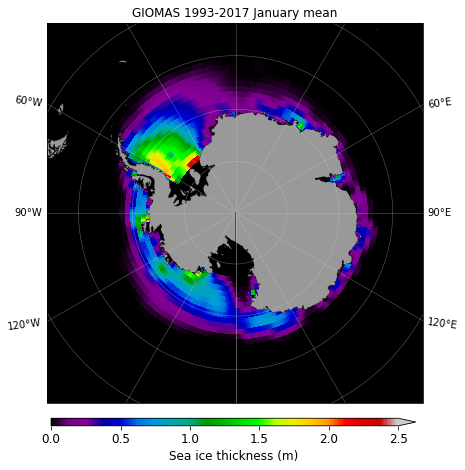

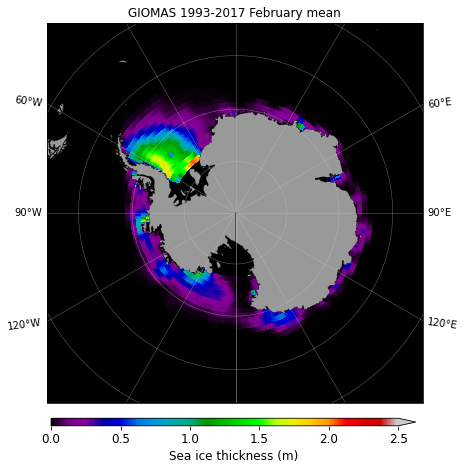

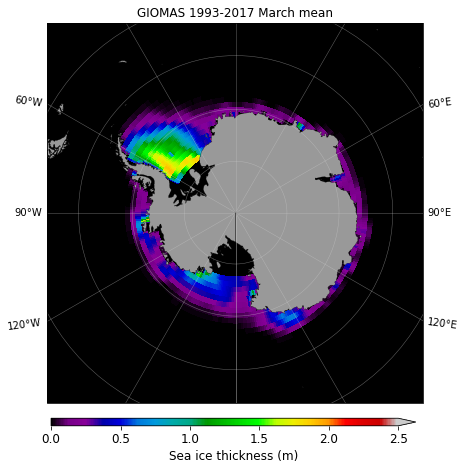

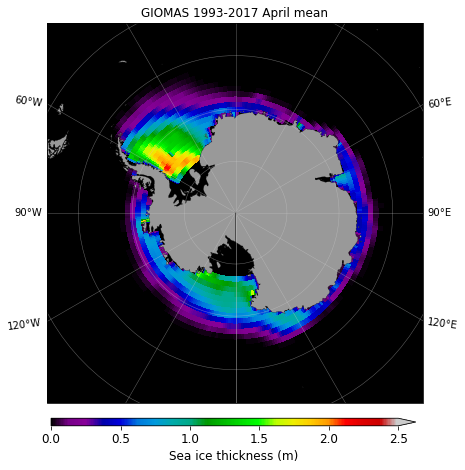

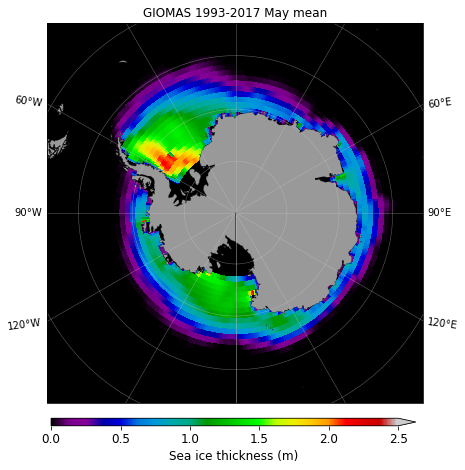

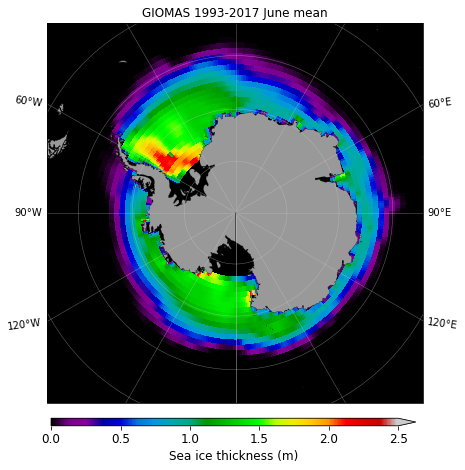

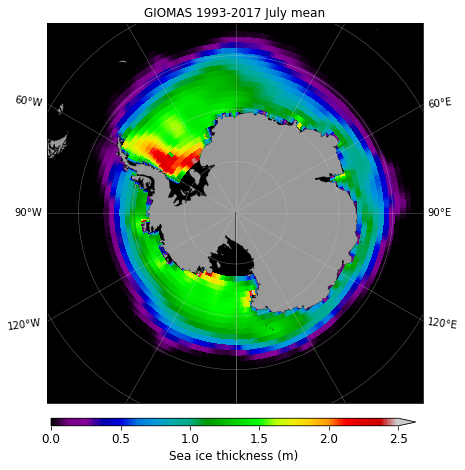

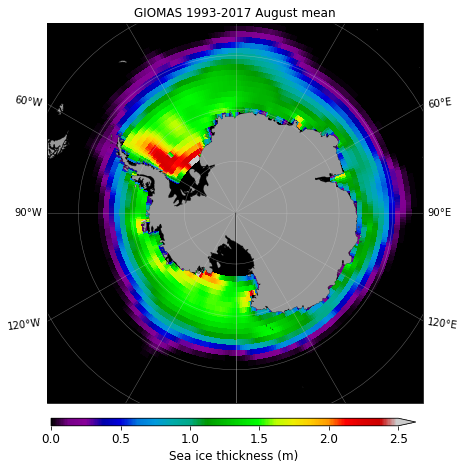

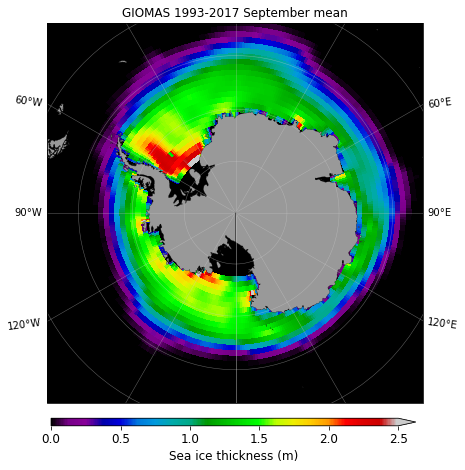

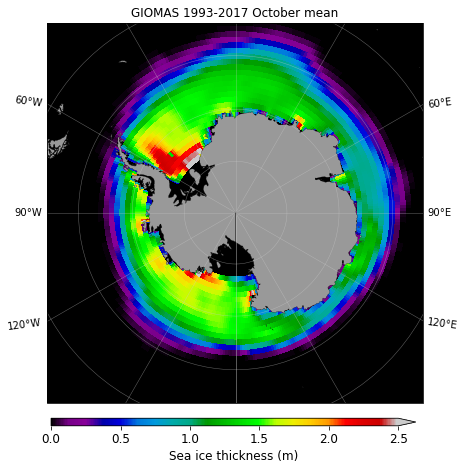

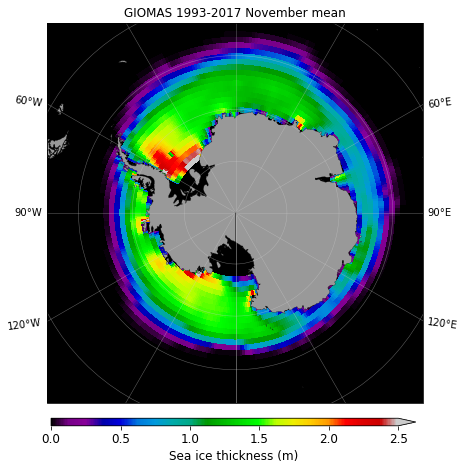

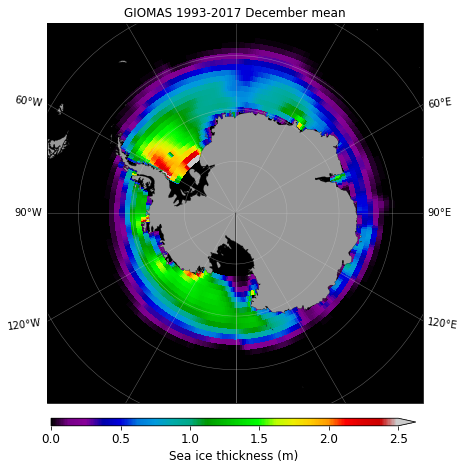

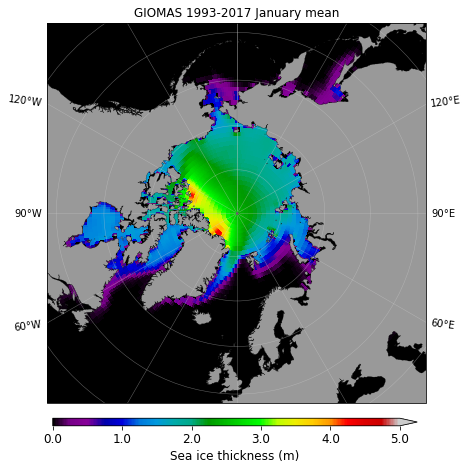

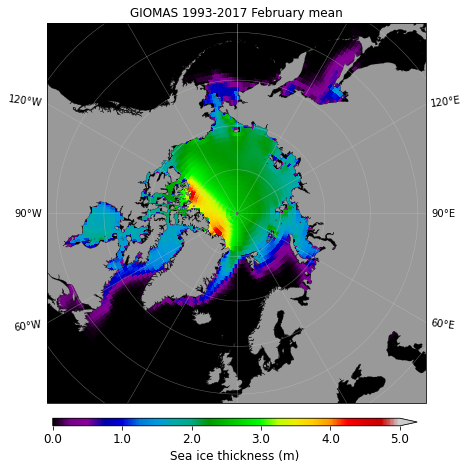

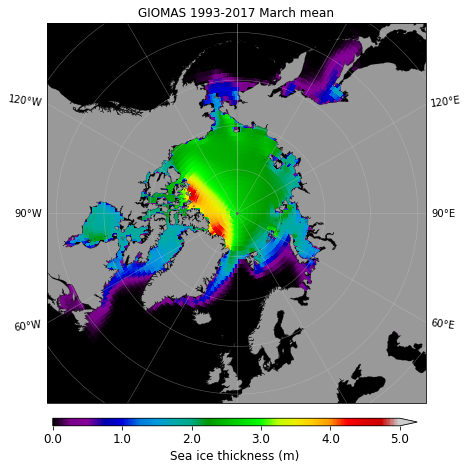

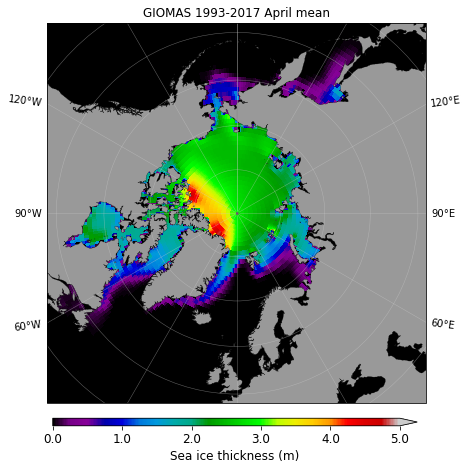

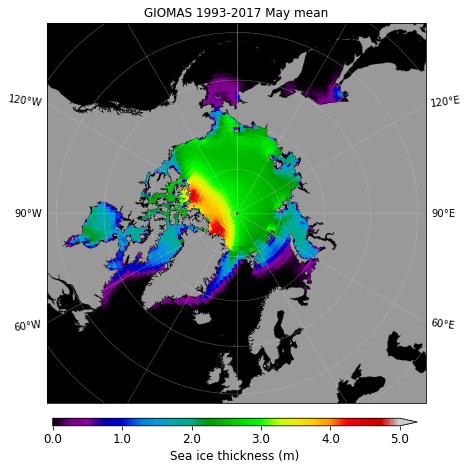

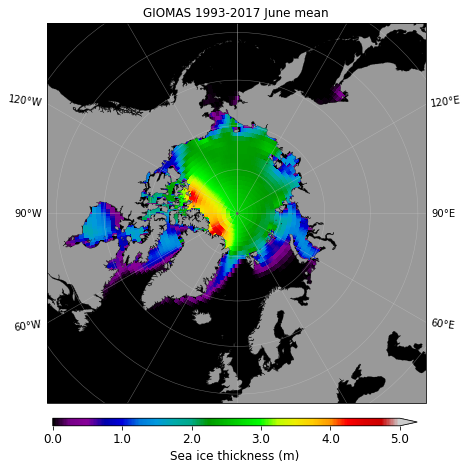

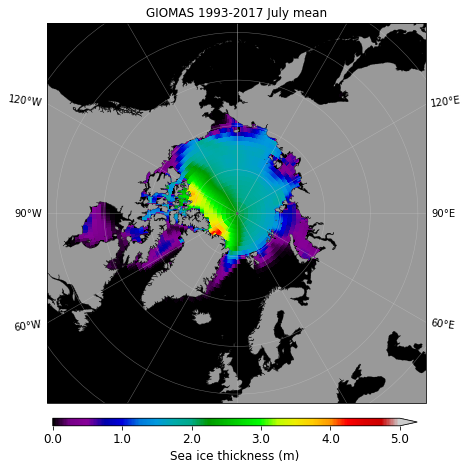

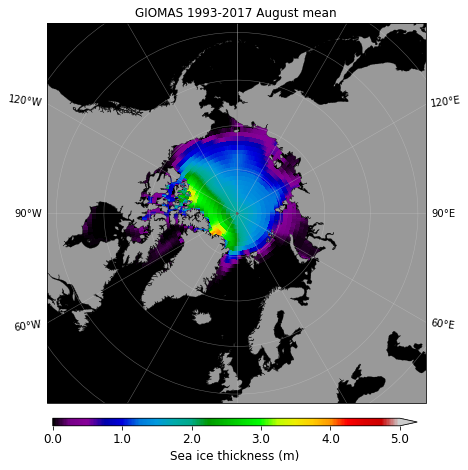

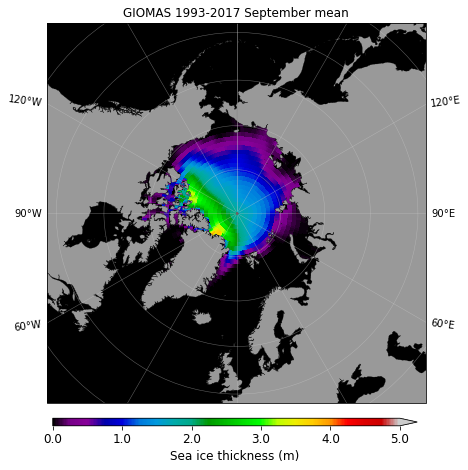

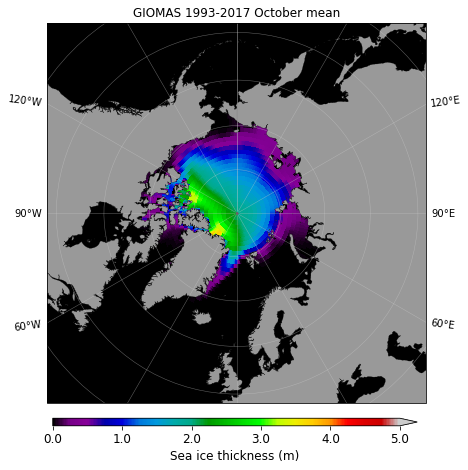

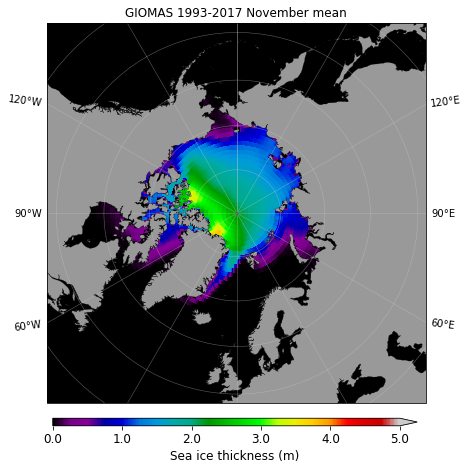

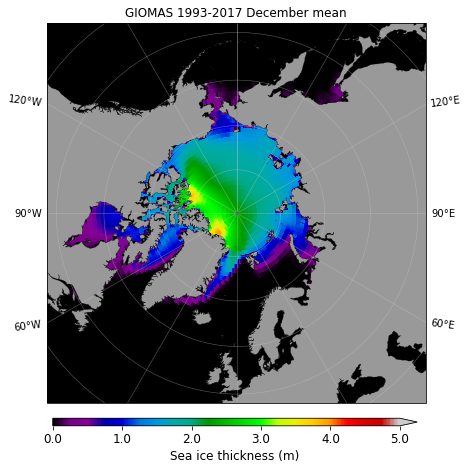

In [76]:
# plot monthly climatologies of SIT from GIOMAS
for viewname, view in views.items():
    print(viewname)
    if viewname == 'NH':
        cbar_ticklevels=np.arange(0, 5.01, 1.0)
    elif viewname == 'Amundsen-Bellingshausen':
        cbar_ticklevels=np.arange(0, 3.501, 0.5)
    else:
        cbar_ticklevels=np.arange(0, 2.501, 0.5)
    for m in range(1,13):
        title = ' '.join(['GIOMAS', yearrange, calendar.month_name[m], 'mean'])
        fname = figname('_'.join([viewname, 'hi_m_mm', 'GIOMAS', yearrange, 'mean', 'month', str(m).zfill(2)]))
        if os.path.exists(fname):
            print('   -- skipping', fname)
        else:
            v = GIOMAS_mm.sel(month=m)
            print('doing', fname)
            plotSIC(v, cbar_label='Sea ice thickness (m)',
                    cmap_gamma=1., cbar_ticklevels=cbar_ticklevels, cbar_sigfigs=1, extend='max', **view).set_title(title);
            savefigure(fname)
            plt.close()
print('done')

In [23]:
# plot daily SIC from each cycle of each model
for viewname, view in views.items():
    print(viewname)
    for ekey in ice_data.keys():
        for cycle, ide in enumerate(ice_data[ekey], start=1):
            for var in ['aice']:
                for date in ide[var]['time'].data: #[213:578]:
                    datestr = date.strftime('%Y-%m-%d')
                    title = ' '.join([ide['desc'], 'cycle', str(cycle), datestr])
                    fname = figname('_'.join([viewname, var, 
                                              ide['expt'].split('_cycle')[0], 'cycle'+str(cycle), # FRAGLE! assumes filename cycle number = cycle
                                              datestr]))
                    if os.path.exists(fname):
                        print('   -- skipping', fname)
                    else:
                        v = ide[var].sel(time=date)
                        print('doing', fname)
                        plotSIC(v, **view).set_title(title);
                        savefigure(fname)
                        plt.close()
#                         break
            break  # only do cycle 1
print('done')

Amundsen-Bellingshausen
   -- skipping figs/Amundsen-Bellingshausen_aice_1deg_jra55_iaf_omip2-fixed_cycle1_2016-08-01_200dpi.png
   -- skipping figs/Amundsen-Bellingshausen_aice_1deg_jra55_iaf_omip2-fixed_cycle1_2016-08-02_200dpi.png
   -- skipping figs/Amundsen-Bellingshausen_aice_1deg_jra55_iaf_omip2-fixed_cycle1_2016-08-03_200dpi.png
   -- skipping figs/Amundsen-Bellingshausen_aice_1deg_jra55_iaf_omip2-fixed_cycle1_2016-08-04_200dpi.png
   -- skipping figs/Amundsen-Bellingshausen_aice_1deg_jra55_iaf_omip2-fixed_cycle1_2016-08-05_200dpi.png
   -- skipping figs/Amundsen-Bellingshausen_aice_1deg_jra55_iaf_omip2-fixed_cycle1_2016-08-06_200dpi.png
   -- skipping figs/Amundsen-Bellingshausen_aice_1deg_jra55_iaf_omip2-fixed_cycle1_2016-08-07_200dpi.png
   -- skipping figs/Amundsen-Bellingshausen_aice_1deg_jra55_iaf_omip2-fixed_cycle1_2016-08-08_200dpi.png
   -- skipping figs/Amundsen-Bellingshausen_aice_1deg_jra55_iaf_omip2-fixed_cycle1_2016-08-09_200dpi.png
   -- skipping figs/Amundsen-Be

In [23]:
# plot daily ice thickness from each cycle of each model
for viewname, view in views.items():
    print(viewname)
    if viewname == 'NH':
        cbar_ticklevels=np.arange(0, 5.01, 1.0)
    elif viewname == 'Amundsen-Bellingshausen':
        cbar_ticklevels=np.arange(0, 3.501, 0.5)
    else:
        cbar_ticklevels=np.arange(0, 2.501, 0.5)
    for ekey in ice_data.keys():
        for cycle, ide in enumerate(ice_data[ekey], start=1):
            for var in ['hi']:
                for date in ide[var]['time'].data[213:578]:
                    datestr = date.strftime('%Y-%m-%d')
                    title = ' '.join([ide['desc'], 'cycle', str(cycle), datestr])
                    fname = figname('_'.join([viewname, var, 
                                              ide['expt'].split('_cycle')[0], 'cycle'+str(cycle), # FRAGLE! assumes filename cycle number = cycle
                                              datestr]))
                    if os.path.exists(fname):
                        print('   -- skipping', fname)
                    else:
                        v = ide[var].sel(time=date)
                        print('doing', fname)
                        plotSIC(v, cbar_label='Sea ice thickness (m)',
                                cmp=cm.cm.ice,
                                cmap_gamma=1.0, cbar_ticklevels=cbar_ticklevels, cbar_sigfigs=1, extend='max', **view).set_title(title);
                        savefigure(fname)
                        plt.close()
#                         break
            break  # only do cycle 1
print('done')

Amundsen-Bellingshausen
   -- skipping figs/Amundsen-Bellingshausen_hi_1deg_jra55_iaf_omip2-fixed_cycle1_2016-08-01_200dpi.png
   -- skipping figs/Amundsen-Bellingshausen_hi_1deg_jra55_iaf_omip2-fixed_cycle1_2016-08-02_200dpi.png
   -- skipping figs/Amundsen-Bellingshausen_hi_1deg_jra55_iaf_omip2-fixed_cycle1_2016-08-03_200dpi.png
   -- skipping figs/Amundsen-Bellingshausen_hi_1deg_jra55_iaf_omip2-fixed_cycle1_2016-08-04_200dpi.png
   -- skipping figs/Amundsen-Bellingshausen_hi_1deg_jra55_iaf_omip2-fixed_cycle1_2016-08-05_200dpi.png
   -- skipping figs/Amundsen-Bellingshausen_hi_1deg_jra55_iaf_omip2-fixed_cycle1_2016-08-06_200dpi.png
   -- skipping figs/Amundsen-Bellingshausen_hi_1deg_jra55_iaf_omip2-fixed_cycle1_2016-08-07_200dpi.png
   -- skipping figs/Amundsen-Bellingshausen_hi_1deg_jra55_iaf_omip2-fixed_cycle1_2016-08-08_200dpi.png
   -- skipping figs/Amundsen-Bellingshausen_hi_1deg_jra55_iaf_omip2-fixed_cycle1_2016-08-09_200dpi.png
   -- skipping figs/Amundsen-Bellingshausen_hi_1d

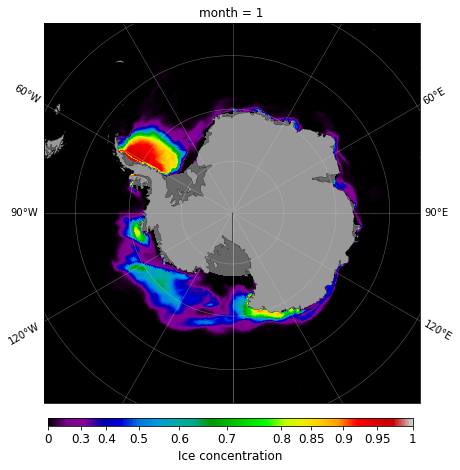

In [53]:
plotSIC(v, **SH);

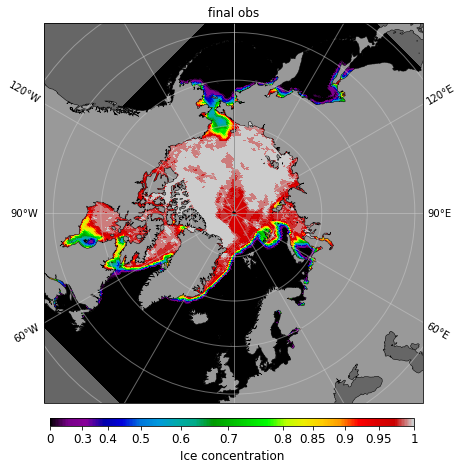

In [22]:
plotSIC(obs_NH.isel(time=-1), **NH).set_title('final obs');

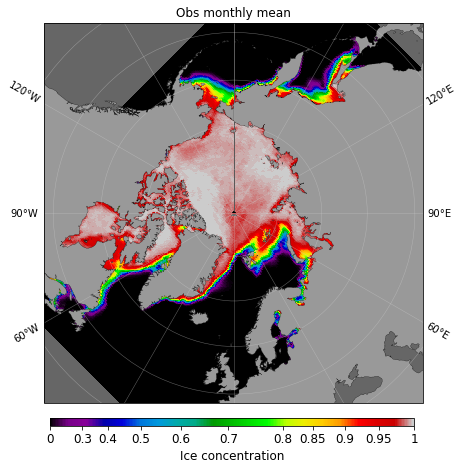

In [25]:
plotSIC(obs_NH_mm.sel(month=1), **NH).set_title('Obs monthly mean');

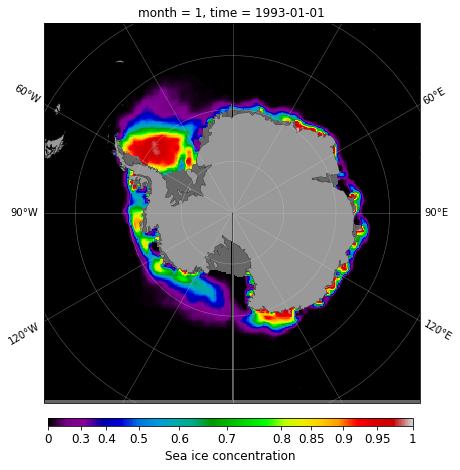

In [27]:
plotSIC(obs_SH_mm.sel(month=1), **SH);

# Timeseries plots

## Time series of sea ice volume (by category), area, extent and snow volume

`vicen_m(time, nc, nj, ni)`
		has units = "m",
so need to multiply by `area_t` to get volume.
`nc` is number of ice categories.

We use kcatbound=0, so lower bound of ice categories is 0, 0.64, 1.39, 2.47, 4.57m (HunkeLipscombTurnerJefferyElliott2015a-CICE5p1, table 2).

Much of the Arctic ice volume (not area) is >4.57m thick, including in the summer minimum.

<font color="FF0000"><B>FIXME:<B> land mask area differs between the three configurations and differs from obs, especially in the Canadian Archipelago and River Ob - how to remove this bias in the total extent, area and volume? Can we at least quantify the area differences poleward of (say) 65N/S?
</font>

In [18]:
initial_transient = False

In [19]:
def calcvol(ide, timerange=timerange):
# WARNING - this can take several minutes
    loaddata(ide, varnames=['hi_m', 'area_t'], timerange=timerange)
    if 'NH_ice_volume' not in ide.keys():
        volume = ide['hi_m']*ide['area_t'] # hi_m(time, nc, nj, ni) has units = "m", so need to multiply by `area_t` to get volume.
        volume_zonalsum = volume.sum('xt_ocean').compute()  # do this once for both NH & SH
        ide['NH_ice_volume'] = volume_zonalsum.sel(yt_ocean=slice(0, 90)).sum('yt_ocean')
        ide['SH_ice_volume'] = volume_zonalsum.sel(yt_ocean=slice(-90,0)).sum('yt_ocean')

In [20]:
def calcvolcat(ide, timerange=timerange):
# WARNING - this can take several minutes
    loaddata(ide, varnames=['vicen_m', 'area_t'], timerange=timerange)
    if 'NH_ice_volume_cat' not in ide.keys():
        volume = ide['vicen_m']*ide['area_t'] # vicen_m(time, nc, nj, ni) has units = "m", so need to multiply by `area_t` to get volume.
        volume_zonalsum = volume.sum('xt_ocean').compute()  # do this once for both NH & SH
        ide['NH_ice_volume_cat'] = volume_zonalsum.sel(yt_ocean=slice(0, 90)).sum('yt_ocean')
        ide['SH_ice_volume_cat'] = volume_zonalsum.sel(yt_ocean=slice(-90,0)).sum('yt_ocean')

In [21]:
def plotvol(v):
    if not initial_transient:
        v = v.sel(time=slice(pd.to_datetime('1985', format='%Y'),tend))  # common time range for all plots
    plt.plot(v['time'],v.isel(nc=c)/1e12, color='C'+str(c), linewidth=1, label='Category '+str(c+1))
#         if not initial_transient:
    plt.plot(v['time'],
             v.rolling(time=12, center=True).mean().isel(nc=c)/1e12, # 12-month rolling mean
             color='C'+str(c), linewidth=2)
#     total
#     plt.plot(v['time'],v.sum(axis=-1)/1e12, color='k', linewidth=1, label='Total')
#     plt.plot(v['time'][6:-5],
#              v.rolling(time=12, center=True).mean().sum(axis=-1)[6:-5]/1e12,  # 12-month rolling mean
#              color='k', linewidth=2)
    plt.ylim(ymin=0)
    plt.xlabel('Year')
    plt.ylabel(r'Ice volume (10$^{12}$ m$^3$)')

In [22]:
def plotvolcumul(v):
    if not initial_transient:
        v = v.sel(time=slice(pd.to_datetime('1985', format='%Y'),tend))  # common time range for all plots
    plt.plot(v['time'],v/1e12, linewidth=1)
#         if not initial_transient:
    plt.plot(v['time'],
             v.rolling(time=12, center=True).mean()/1e12, # 12-month rolling mean
             linewidth=2)
    plt.ylim(ymin=0)
    plt.xlabel('Year')
    plt.ylabel(r'Ice volume (10$^{12}$ m$^3$)')

In [23]:
def plotvolcatcumul(v):
    if not initial_transient:
        v = v.sel(time=slice(pd.to_datetime('1985', format='%Y'),tend))  # common time range for all plots
    v = v.cumsum(axis=-1)
    cats = list(range(len(v['nc'])))
    cats.reverse()  # so legend is in same order as plotted data
    for c in cats:
        plt.plot(v['time'],v.isel(nc=c)/1e12, color='C'+str(c), linewidth=1, label='Category '+'+'.join([str(f+1) for f in range(c+1)]))
#         if not initial_transient:
        plt.plot(v['time'],
                 v.rolling(time=12, center=True).mean().isel(nc=c)/1e12, # 12-month rolling mean
                 color='C'+str(c), linewidth=2)
    plt.ylim(ymin=0)
    plt.xlabel('Year')
    plt.ylabel(r'Ice volume (10$^{12}$ m$^3$)')

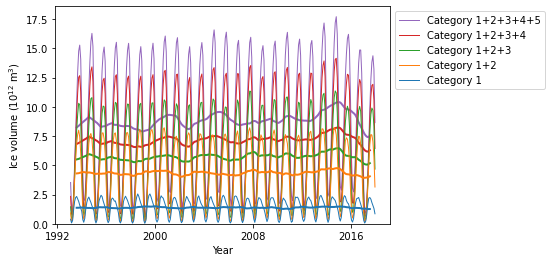

In [111]:
plotvolcatcumul(ice_data['1deg'][0]['SH_ice_volume_cat'])
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

## Seasonal cycle of sea ice extent and area
We adopt the usual definition of sea ice extent as the area in which sea ice concentration exceeds 15\%.

- obs in `/g/data3/hh5/tmp/cosima/observations/NOAA/G02135/north/monthly/data/*.csv` and  `/g/data3/hh5/tmp/cosima/observations/NOAA/G02135/south/monthly/data/*.csv`
- file names `N_mm_extent_v3.0.csv`, `S_mm_extent_v3.0.csv` where `mm` is month number
- first full year: 1979
- last full year: 2017
- missing extent data (-9999): Dec 1987, Jan 1988

CSV format:
```
year, mo,    data-type, region, extent,   area
1978, 12,      Goddard,      N,  13.67,  10.90
...
```


In [33]:
def loadObsExt(fnlist):
    """
    Return xarray DataSet of sea ice extent and area from NOAA/G02135 csv file list
    """
    df = pd.concat([pd.read_csv(f) for f in fnlist])  # read all csv files into a pandas DataFrame
    df.columns = df.columns.str.strip()  # remove leading/trailing whitespace from headers
#     df['time'] = df.apply(lambda r: datetime(r['year'], r['mo'], 1), axis=1)  # make a date column (set day=1 to match cice output)
    df['time'] = df.apply(lambda r: cftime.DatetimeGregorian(r['year'], r['mo'], 1), axis=1)  # make a date column (set day=1 to match cice output)
#     print(df)
    df = df.drop(columns=['year', 'mo', 'data-type', 'region'])  # remove redundant columns
    num = df._get_numeric_data()
    num[num < 0] = np.nan  # replace bad data with NaN
    df = df.sort_values('time')
    ds = df.to_xarray()  # convert to xarray DataSet
    ds = ds.assign_coords(index=ds['time']).drop('time')  # set index values to time and remove time
    ds['extent'] = ds.extent.rename({'index': 'time'})  # rename extent coord to time
    ds['area'] = ds.area.rename({'index': 'time'})  # rename area coord to time
    ds = ds.drop('index')  # remove index
    ds = ds*1e12  # convert from M km^2 to m^2
    return ds

In [34]:
obs_ext_NH = loadObsExt(obsExtNHFileList)
obs_ext_NH_mm = obs_ext_NH.sel(time=slice(tstart,tend)).groupby('time.month').mean('time', skipna=True)
obs_ext_SH = loadObsExt(obsExtSHFileList)
obs_ext_SH_mm = obs_ext_SH.sel(time=slice(tstart,tend)).groupby('time.month').mean('time', skipna=True)

In [26]:
def calcarea(ide, timerange=timerange):
    loaddata(ide, varnames=['aice_m', 'area_t'], timerange=timerange)
    if 'NH_area' not in ide.keys():
        area = ide['aice_m']*ide['area_t']
        area_zonalsum = area.sum('xt_ocean').compute()  # do this once for both NH & SH
        ide['NH_area'] = area_zonalsum.sel(yt_ocean=slice(0, 90)).sum('yt_ocean')
        ide['SH_area'] = area_zonalsum.sel(yt_ocean=slice(-90,0)).sum('yt_ocean')
        ide['NH_area_clim'] = ide['NH_area'].sel(time=slice(tstart,tend)).groupby('time.month').mean('time', skipna=True)
        ide['SH_area_clim'] = ide['SH_area'].sel(time=slice(tstart,tend)).groupby('time.month').mean('time', skipna=True)

In [27]:
def calcextent(ide, timerange=timerange):
    loaddata(ide, varnames=['aice_m', 'area_t'], timerange=timerange)
    if 'NH_extent' not in ide.keys():
        extent = xr.where(ide['aice_m'] > 0.15, ide['area_t'], 0)
        extent_zonalsum = extent.sum('xt_ocean').compute()  # do this once for both NH & SH
        ide['NH_extent'] = extent_zonalsum.sel(yt_ocean=slice(0, 90)).sum('yt_ocean')
        ide['SH_extent'] = extent_zonalsum.sel(yt_ocean=slice(-90,0)).sum('yt_ocean')
        ide['NH_extent_clim'] = ide['NH_extent'].sel(time=slice(tstart,tend)).groupby('time.month').mean('time', skipna=True)
        ide['SH_extent_clim'] = ide['SH_extent'].sel(time=slice(tstart,tend)).groupby('time.month').mean('time', skipna=True)

In [28]:
def plotarea(v, obs):
    v = v.sel(time=slice(pd.to_datetime('1985', format='%Y'),tend))  # common time range for all plots
    plt.plot(v['time'],v/1e12, color='r', linewidth=1, label='Model')
    plt.plot(v['time'],
             v.rolling(time=12, center=True).mean()/1e12, # 12-month rolling mean
             color='r', linewidth=2)

    obs = obs.sel(time=slice(pd.to_datetime('1985', format='%Y'),tend))  # common time range for all plots
    plt.plot(obs['time'],obs/1e12, color='k', linewidth=1, label='Obs')
    plt.plot(obs['time'],
             obs.rolling(time=12, center=True).mean()/1e12, # 12-month rolling mean
             color='k', linewidth=2)

    plt.ylim(ymin=0)
    plt.xlabel('Year',font)
    plt.ylabel(r'Ice area (10$^{12}$ m$^2$)',font)

In [29]:
def plotareaNHSH():
    plt.figure(1,(12,5))
    plt.clf()

    plt.subplot(2,1,1)
    plotarea(NH_area, obs_ext_NH.area)
    plt.title('Arctic ice area, '+exptdata.exptdict[ekey]['desc'],font)

    plt.subplot(2,1,2)
    plotarea(SH_area, obs_ext_SH.area)
    plt.title('Antarctic ice area, '+exptdata.exptdict[ekey]['desc'],font)
    plt.legend(prop=font,loc='upper left', bbox_to_anchor=(1, 1))

    plt.tight_layout()

    savefigure('ice_area_'+ekey)

In [30]:
def plotextent(v, obs):
    v = v.sel(time=slice(pd.to_datetime('1985', format='%Y'),tend))  # common time range for all plots
    plt.plot(v['time'],v/1e12, color='r', linewidth=1, label='Model')
    plt.plot(v['time'],
             v.rolling(time=12, center=True).mean()/1e12, # 12-month rolling mean
             color='r', linewidth=2)

    obs = obs.sel(time=slice(pd.to_datetime('1985', format='%Y'),tend))  # common time range for all plots
    plt.plot(obs['time'],obs/1e12, color='k', linewidth=1, label='Obs')
    plt.plot(obs['time'],
             obs.rolling(time=12, center=True).mean()/1e12, # 12-month rolling mean
             color='k', linewidth=2)

    plt.ylim(ymin=0)
    plt.xlabel('Year',font)
    plt.ylabel(r'Ice extent (10$^{12}$ m$^2$)',font)

In [31]:
def plotextentNHSH():
    plt.figure(1,(12,5))
    plt.clf()

    plt.subplot(1,2,1)
    plotextent(NH_extent, obs_ext_NH.extent)
    plt.title('Arctic ice extent, '+exptdata.exptdict[ekey]['desc'],font)

    plt.subplot(1,2,2)
    plotextent(SH_extent, obs_ext_SH.extent)
    plt.title('Antarctic ice extent, '+exptdata.exptdict[ekey]['desc'],font)
    plt.legend(prop=font,loc='upper left', bbox_to_anchor=(1, 1))

    plt.tight_layout()

    savefigure('ice_extent_'+ekey)

In [32]:
for ekey in ice_data.keys():
    for ide in ice_data[ekey]:
        calcvol(ide)
        calcarea(ide)
        calcextent(ide)
#         break  # only load cycle 1
#     break

xt_ocean loaded from /g/data/ik11/grids/ocean_grid_10.nc
yt_ocean loaded from /g/data/ik11/grids/ocean_grid_10.nc
geolon_t loaded from /g/data/ik11/grids/ocean_grid_10.nc
geolat_t loaded from /g/data/ik11/grids/ocean_grid_10.nc
area_t loaded from /g/data/ik11/grids/ocean_grid_10.nc
hi_m
area_t
aice_m
area_t
aice_m
area_t
xt_ocean loaded from /g/data/ik11/grids/ocean_grid_10.nc
yt_ocean loaded from /g/data/ik11/grids/ocean_grid_10.nc
geolon_t loaded from /g/data/ik11/grids/ocean_grid_10.nc
geolat_t loaded from /g/data/ik11/grids/ocean_grid_10.nc
area_t loaded from /g/data/ik11/grids/ocean_grid_10.nc
hi_m
area_t
aice_m
area_t
aice_m
area_t
xt_ocean loaded from /g/data/ik11/grids/ocean_grid_10.nc
yt_ocean loaded from /g/data/ik11/grids/ocean_grid_10.nc
geolon_t loaded from /g/data/ik11/grids/ocean_grid_10.nc
geolat_t loaded from /g/data/ik11/grids/ocean_grid_10.nc
area_t loaded from /g/data/ik11/grids/ocean_grid_10.nc
hi_m
area_t
aice_m
area_t
aice_m
area_t
xt_ocean loaded from /g/data/ik

In [45]:
# 12-mo running mean minimum, mean and maximum of volume for all models
for cycle in range(1, 7): #range(1, 4):
    plt.figure(1,(12,5))
    for c, e in enumerate(ice_data.values()):
        try:
            ide = e[cycle-1]
            plt.subplot(1,2,1)
            v = ide['NH_ice_volume']/1e12
            plt.plot(v['time'][6:-5],v.rolling(time=12, center=True).max()[6:-5], color='C'+str(c), linewidth=1, label=ide['desc'])
            plt.plot(v['time'][6:-5],v.rolling(time=12, center=True).mean()[6:-5], color='C'+str(c), linewidth=1)
            plt.plot(v['time'][6:-5],v.rolling(time=12, center=True).min()[6:-5], color='C'+str(c), linewidth=1)

            plt.subplot(1,2,2)
            v = ide['SH_ice_volume']/1e12
            plt.plot(v['time'][6:-5],v.rolling(time=12, center=True).max()[6:-5], color='C'+str(c), linewidth=1, label=ide['desc'])
            plt.plot(v['time'][6:-5],v.rolling(time=12, center=True).mean()[6:-5], color='C'+str(c), linewidth=1)
            plt.plot(v['time'][6:-5],v.rolling(time=12, center=True).min()[6:-5], color='C'+str(c), linewidth=1)
        except:
            pass

    plt.subplot(1,2,1)
    plt.ylim(ymin=0,ymax=40)
    plt.grid(axis='y')
    plt.xlabel('Year')
    plt.ylabel(r'Sea ice volume (10$^{12}$ m$^3$)')
    plt.title('Arctic ice volume min, mean and max, cycle ' + str(cycle))
    plt.subplot(1,2,2)
    plt.ylim(ymin=0,ymax=22)
    plt.grid(axis='y')
    plt.xlabel('Year')
    plt.ylabel(r'Sea ice volume (10$^{12}$ m$^3$)')
    plt.title('Antarctic ice volume min, mean and max, cycle ' + str(cycle))
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

    plt.tight_layout()
    
    fname = os.path.join('figs', 'ice_volume_min_mean_max_all_cycle'+str(cycle)+'.pdf')
    plt.savefig(fname, bbox_inches='tight')
    plt.close()

In [42]:
# 12-mo running mean minimum, mean and maximum of area for all models
for cycle in range(1, 7): #range(1, 4):
    plt.figure(1,(12,5))
    for c, e in enumerate(ice_data.values()):
        try:
            ide = e[cycle-1]
            plt.subplot(1,2,1)
            v = ide['NH_area']/1e12
            plt.plot(v['time'][6:-5],v.rolling(time=12, center=True).max()[6:-5], color='C'+str(c), linewidth=1, label=ide['desc'])
            plt.plot(v['time'][6:-5],v.rolling(time=12, center=True).mean()[6:-5], color='C'+str(c), linewidth=1)
            plt.plot(v['time'][6:-5],v.rolling(time=12, center=True).min()[6:-5], color='C'+str(c), linewidth=1)

            plt.subplot(1,2,2)
            v = ide['SH_area']/1e12
            plt.plot(v['time'][6:-5],v.rolling(time=12, center=True).max()[6:-5], color='C'+str(c), linewidth=1, label=ide['desc'])
            plt.plot(v['time'][6:-5],v.rolling(time=12, center=True).mean()[6:-5], color='C'+str(c), linewidth=1)
            plt.plot(v['time'][6:-5],v.rolling(time=12, center=True).min()[6:-5], color='C'+str(c), linewidth=1)
        except:
            pass

    plt.subplot(1,2,1)
    v = obs_ext_NH.area/1e12
    plt.plot(v['time'][6:-5],v.rolling(time=12, center=True).max()[6:-5], color='k', linewidth=1, label='Observations')
    plt.plot(v['time'][6:-5],v.rolling(time=12, center=True).mean()[6:-5], color='k', linewidth=1)
    plt.plot(v['time'][6:-5],v.rolling(time=12, center=True).min()[6:-5], color='k', linewidth=1)

    plt.subplot(1,2,2)
    v = obs_ext_SH.area/1e12
    plt.plot(v['time'][6:-5],v.rolling(time=12, center=True).max()[6:-5], color='k', linewidth=1, label='Observations')
    plt.plot(v['time'][6:-5],v.rolling(time=12, center=True).mean()[6:-5], color='k', linewidth=1)
    plt.plot(v['time'][6:-5],v.rolling(time=12, center=True).min()[6:-5], color='k', linewidth=1)

    plt.subplot(1,2,1)
    plt.ylim(ymin=0,ymax=22)
    plt.grid(axis='y')
    plt.xlabel('Year')
    plt.ylabel(r'Sea ice area (10$^{12}$ m$^2$)')
    plt.title('Arctic ice area min, mean and max, cycle ' + str(cycle))
    plt.subplot(1,2,2)
    plt.ylim(ymin=0,ymax=22)
    plt.grid(axis='y')
    plt.xlabel('Year')
    plt.ylabel(r'Sea ice area (10$^{12}$ m$^2$)')
    plt.title('Antarctic ice area min, mean and max, cycle ' + str(cycle))
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

    plt.tight_layout()
    
    fname = os.path.join('figs', 'ice_area_min_mean_max_all_cycle'+str(cycle)+'.pdf')
    plt.savefig(fname, bbox_inches='tight')
    plt.close()

In [41]:
# 12-mo running mean minimum, mean and maximum of extent for all models
for cycle in range(1, 7): #range(1, 4):
    plt.figure(1,(12,5))
    for c, e in enumerate(ice_data.values()):
        try:
            ide = e[cycle-1]
            plt.subplot(1,2,1)
            v = ide['NH_extent']/1e12
            plt.plot(v['time'][6:-5],v.rolling(time=12, center=True).max()[6:-5], color='C'+str(c), linewidth=1, label=ide['desc'])
            plt.plot(v['time'][6:-5],v.rolling(time=12, center=True).mean()[6:-5], color='C'+str(c), linewidth=1)
            plt.plot(v['time'][6:-5],v.rolling(time=12, center=True).min()[6:-5], color='C'+str(c), linewidth=1)

            plt.subplot(1,2,2)
            v = ide['SH_extent']/1e12
            plt.plot(v['time'][6:-5],v.rolling(time=12, center=True).max()[6:-5], color='C'+str(c), linewidth=1, label=ide['desc'])
            plt.plot(v['time'][6:-5],v.rolling(time=12, center=True).mean()[6:-5], color='C'+str(c), linewidth=1)
            plt.plot(v['time'][6:-5],v.rolling(time=12, center=True).min()[6:-5], color='C'+str(c), linewidth=1)
        except:
            pass

    plt.subplot(1,2,1)
    v = obs_ext_NH.extent/1e12
    plt.plot(v['time'][6:-5],v.rolling(time=12, center=True).max()[6:-5], color='k', linewidth=1, label='Observations')
    plt.plot(v['time'][6:-5],v.rolling(time=12, center=True).mean()[6:-5], color='k', linewidth=1)
    plt.plot(v['time'][6:-5],v.rolling(time=12, center=True).min()[6:-5], color='k', linewidth=1)

    plt.subplot(1,2,2)
    v = obs_ext_SH.extent/1e12
    plt.plot(v['time'][6:-5],v.rolling(time=12, center=True).max()[6:-5], color='k', linewidth=1, label='Observations')
    plt.plot(v['time'][6:-5],v.rolling(time=12, center=True).mean()[6:-5], color='k', linewidth=1)
    plt.plot(v['time'][6:-5],v.rolling(time=12, center=True).min()[6:-5], color='k', linewidth=1)

    plt.subplot(1,2,1)
    plt.ylim(ymin=0,ymax=22)
    plt.grid(axis='y')
    plt.xlabel('Year')
    plt.ylabel(r'Sea ice extent (10$^{12}$ m$^2$)')
    plt.title('Arctic ice extent min, mean and max, cycle ' + str(cycle))
    plt.subplot(1,2,2)
    plt.ylim(ymin=0,ymax=22)
    plt.grid(axis='y')
    plt.xlabel('Year')
    plt.ylabel(r'Sea ice extent (10$^{12}$ m$^2$)')
    plt.title('Antarctic ice extent min, mean and max, cycle ' + str(cycle))
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

    plt.tight_layout()
    
    fname = os.path.join('figs', 'ice_extent_min_mean_max_all_cycle'+str(cycle)+'.pdf')
    plt.savefig(fname, bbox_inches='tight')
    plt.close()